In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from utility import analysis_parameters as ap
import cartopy.crs as ccrs
import numpy as np
import netCDF4 as nc
import dask
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

var="rlt"
var1="rlut"
chunk_dict = {"lat":100, "lon":100, "latitude":100, "longitude":100}
diff=True
lev=0

# global tropical mean plot

In [2]:
# load variables into an array
if var=="rlt":
    models = ["SCREAMr1deg", "SAMr1deg", "ARPr1deg", "ICONr1deg"]
    models1= ["UMr1deg", "GEOSr1deg", "SHiELDr1deg"]
    da = xr.open_dataset(ap.get_timmean_file("CERES","GT","rad_toa_1hm_JFM")).adj_atmos_lw_up_all_toa_1hm.mean(dim="time")
    mod = {"CERES 1HM":da}
    print(da.shape)
    
    chunk_dict = {"lat":100, "lon":100, "latitude":100, "longitude":100}

    for m in models:
        print(m)
        dmod = xr.open_dataset(ap.get_timmean_file(m, "GT", var), chunks=chunk_dict)[var][0]
        if m=="ARPr0.25deg":
            dmod=-dmod/900
        if diff:
            dam = da.interp({"lon":dmod.lon, "lat":dmod.lat})
            das = dmod - dam.values
            mod[m] = das
        else:
            mod[m] = dmod
    for m in models1:
        print(m)
        if (m=="NICAMr1deg") or (m=="UMr1deg"):
            dmod = xr.open_dataset(ap.get_timmean_file(m, "GT", var1), chunks=chunk_dict)[var1]
        else:
            dmod = xr.open_dataset(ap.get_timmean_file(m, "GT", var1), chunks=chunk_dict)[var1][0]
        if m[:2]=="UM":
            dam = da.interp({"lon":dmod.longitude.values, "lat":dmod.latitude.values})
        else:
            dam = da.interp({"lon":dmod.lon, "lat":dmod.lat})
        if diff:
            das = dmod - dam.values
            mod[m] = das
        else:
            mod[m] = dmod

elif var=="cli":
    all_models = ["SCREAMr0.25deg", "UM", "NICAM", "SAM"]
    das = [xr.open_dataset(ap.get_timmean_file(m, "GT_14-18km", "cldfrac"), chunks=chunk_dict)["cli"].mean(dim=["time"]) for m in all_models]
    mod_ttl = dict(zip(all_models, das))
    mod={}
    for m in all_models:
        print(m, mod_ttl[m].shape)
        if m=="SCREAMr0.25deg" or m=="GEOSr0.25deg":
            mod[m] = mod_ttl[m].isel(lev=-1)
        elif m=="SAM":
            mod[m] = mod_ttl[m].isel(z=0)
        elif m=="UM":
            mod[m] = mod_ttl[m].isel(model_level_number=0)
        else:
            mod[m] = mod_ttl[m].isel(lev=0)
        print(mod[m].shape)

(60, 360)
SCREAMr1deg
SAMr1deg
ARPr1deg
ICONr1deg
UMr1deg
GEOSr1deg
SHiELDr1deg


In [3]:
mod["SCREAMr1deg"]

<xarray.DataArray 'rlt' (lat: 60, lon: 360)>
dask.array<sub, shape=(60, 360), dtype=float64, chunksize=(60, 100), chunktype=numpy.ndarray>
Coordinates:
    time     object 2020-02-13 23:52:30
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5

0
1
[########################################] | 100% Completed |  0.1s
2
[########################################] | 100% Completed |  0.1s
3
[########################################] | 100% Completed |  0.1s
4
[########################################] | 100% Completed |  0.1s
5
[########################################] | 100% Completed |  0.1s
6
[########################################] | 100% Completed |  0.1s
7
[########################################] | 100% Completed |  0.1s


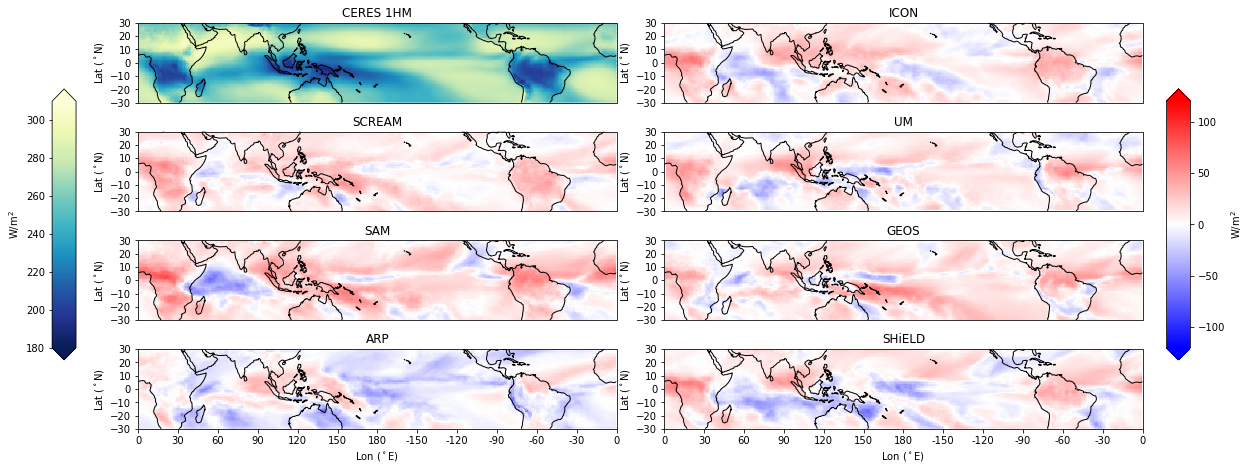

In [10]:
# fig, ax = plt.subplots(len(mod),1, figsize=(8,2*len(mod)), 
#                        subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)},
#                        sharex=True, sharey=True)
fig = plt.figure(figsize=(18,len(mod)))
gs = fig.add_gridspec(len(mod)//2,2, wspace=0.1, hspace=0.0, width_ratios=[1,1])
ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
cmap = "YlGnBu_r"
vmin, vmax = 180, 310
im = mod["CERES 1HM"].plot(
        ax=ax0,
        transform=ccrs.PlateCarree(),  
        cmap=cmap,
        vmin=vmin, vmax=vmax, add_colorbar=False,
    )
ax0.coastlines()
ax0.set_title(m.split("r")[0])
ax0.set_yticks(np.arange(-30,31,10))
ax0.set_ylabel("Lat ($^\circ$N)")
ax0.set_title("CERES 1HM")
ax0.set_ylim([-30,30])


if var[:3]=="cli":
    omin, omax = 0, 0.6
    lab = "cld frac"
else:
    omin, omax = 180, 310
    dmin, dmax = -120, 120
    lab = "OLR (W/m2)"
i=0
for m in list(mod.keys()):
    print(i)
    if var=="cli":
        if m=="UM":
            lev="model_level_number"
        else:
            lev="lev"
    da = mod[m]
    if diff:
        if m=="CERES 1HM":
            vmin=omin
            vmax=omax
            cmap = "YlGnBu_r"
        else:
            vmin, vmax = dmin, dmax
            cmap = "bwr"
    else:
        cmap="YlGnBu_r"
        vmin=omin
        vmax=omax
    if m=="CERES 1HM":
        i+=1
        continue
    ax = fig.add_subplot(gs[i%(len(mod)//2),i//(len(mod)//2)], projection=ccrs.PlateCarree(central_longitude=180), sharex=ax0)

    pc = da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),  
        cmap=cmap,
        vmin=vmin, vmax=vmax, add_colorbar=False,
        # cbar_kwargs={"orientation": "vertical", "shrink": 0.7,"label":lab},
        # robust=True
    )
    ax.coastlines() 
    ax.set_title(m.split("r")[0])
    ax.set_yticks(np.arange(-30,31,10))
    # ax.set_xticks(np.arange(-180,181,30))
    ax.set_ylabel("Lat ($^\circ$N)")
    ax.set_ylim([-30,30])
    if i==2:
        axins2 = inset_axes(ax, # here using axis of the lowest plot
                   width="5%",  # width = 5% of parent_bbox width
                   height="340%",  # height : 340% good for a (4x4) Grid
                   loc='lower left',
                   bbox_to_anchor=(-0.18, -0.5, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
    if i==6:
        axins6 = inset_axes(ax, # here using axis of the lowest plot
                   width="5%",  # width = 5% of parent_bbox width
                   height="340%",  # height : 340% good for a (4x4) Grid
                   loc='lower left',
                   bbox_to_anchor=(1.05, -0.5, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )
    if i%4==3:
        ax.set_xticks(np.arange(-180,181,30))
        ax.set_xticklabels([0,30,60,90,120,150,180,-150,-120,-90,-60,-30,0],color='k')
        ax.set_xlabel("Lon ($^\circ$E)")
    i+=1

cb = fig.colorbar(im, cax=axins2, extend="both", label="W/m$^2$", ticklocation="left")
cb = fig.colorbar(pc, cax=axins6, extend="both", label="W/m$^2$")

if diff:
    var=var+"_diff"

plt.savefig("../plots/GT/timmean_{}.png".format(var), dpi=250)
plt.show()

if diff:
    var=var.split("_")[0]

# TTL cld frac

In [ ]:
ds = xr.open_dataset("/work/bb1153/b380883/GT/timmean/timmean_GT_14-18km_SCREAMr0.25deg_ttlcldmask_20200130-20200228.nc").pfull
ds = ds.mean(dim=["time","lev"])
ds

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,12), 
                       subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)},
                       constrained_layout=True)
cmap = "YlGnBu_r"
i=0
(ds*100).plot(transform=ccrs.PlateCarree(),  
              ax=ax[i],
            cmap=cmap,
            vmin=0, vmax=2,
            cbar_kwargs={"orientation": "vertical", "shrink": 0.5,"label":"TTL cld frac (%)"},
            robust=True
    )
ax[i].coastlines() 
ax[i].set_xticks(np.arange(-180,181,30))
ax[i].set_xticklabels([0,30,60,90,120,150,180,-150,-120,-90,-60,-30,0])
ax[i].set_yticks(np.arange(-30,31,10))
ax[i].set_title(all_models[i]+" "+var)
ax[i].set_xlabel("Lon ($^\circ$E)")
ax[i].set_ylabel("Lat ($^\circ$N)")
ax[i].set_ylim([-30,30])

In [4]:
### tropical cirrus coverage

clt = xr.open_dataset("/work/bb1153/b380883/GT/GT_SCREAMr0.1deg_clt_20200130-20200228.nc", chunks=500).clt
clt

<xarray.DataArray 'clt' (time: 2688, lat: 600, lon: 3600)>
dask.array<open_dataset-b3adcc9b01866b55eb33d87ce3fc64daclt, shape=(2688, 600, 3600), dtype=float32, chunksize=(500, 500, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2020-01-30 00:00:00 ... 2020-02-28 23:45:00
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.5 359.6 359.7 359.8 359.9
  * lat      (lat) float64 -29.95 -29.85 -29.75 -29.65 ... 29.75 29.85 29.95
Attributes:
    standard_name:  cloud_area_fraction
    long_name:      Vertically-integrated total cloud
    units:          1
    origin:         CLDTOT

In [ ]:
clt.mean(axis=0).plot(y="lat")
plt.show()

[#                                       ] | 3% Completed |  4min 19.1s

In [ ]:
# # compare remapdis vs remapcon with different scales

# og = xr.open_dataset("/work/bb1153/b380883/TWP/TWP_SHiELDr0.1deg_rlut_20200130-20200228.nc").rlut.sel(time=slice("2020-02-22T00:15","2020-02-23T00:00"))
# co = xr.open_dataset("/work/bb1153/b380883/TWP/SHiELD_remapcon_testr0.1deg.nc").rlut

# og.shape, co.shape

# og.time[0].values, co.time[0].values

# plt.scatter(og.values.flatten(), co.values.flatten(), label="r="+str(xr.corr(og, co).values))
# plt.plot([75,275],[75,275], color="k")
# plt.xlabel("cdo remapdis,r3600x1800")
# plt.ylabel("cdo remapcon,r3600x1800")
# plt.title("OLR SHiELD 2020-02-22 0.1 deg")
# plt.legend()
# plt.savefig("../plots/r_value_OLR_SHiELD_remapconVSremapdis.png", dpi=140)
# plt.show()


# i=2
# og = og.coarsen(lat=i, lon=i, boundary="trim").mean()
# co = xr.open_dataset("/work/bb1153/b380883/TWP/SHiELD_remapcon_testr0.2deg.nc").rlut[:,:,:50]
# co.shape, og.shape

# plt.scatter(og.values.flatten(), co.values.flatten(), label="r="+str(np.corrcoef(og.values.flatten(), co.values.flatten())[0,1]))
# plt.plot([75,275],[75,275], color="k")
# plt.xlabel("cdo remapdis,r3600x1800")
# plt.ylabel("cdo remapcon,r3600x1800")
# plt.title("OLR SHiELD 2020-02-22 0.2 deg")
# plt.legend()
# plt.savefig("../plots/r_value_OLR_SHiELD_remapconVSremapdis0.2deg.png", dpi=140)
# plt.show()

# i=10
# og = og.coarsen(lat=i, lon=i, boundary="trim").mean()
# co = xr.open_dataset("/work/bb1153/b380883/TWP/SHiELD_remapcon_testr1deg.nc").rlut[:,:,:10]
# co.shape, og.shape

# plt.figure()
# plt.scatter(og.values.flatten(), co.values.flatten(), label="r="+str(np.corrcoef(og.values.flatten(), co.values.flatten())[0,1]))
# plt.xlabel("cdo remapdis,r3600x1800")
# plt.ylabel("cdo remapcon,r3600x1800")
# plt.title("OLR SHiELD 2020-02-22 1 deg")
# plt.legend()
# plt.savefig("../plots/r_value_OLR_SHiELD_remapconVSremapdis1deg.png", dpi=140)
# plt.show()